Log the concentrations to and learn the models for CaCO3 again to avoid 0 happen in the prediction.

In [1]:
import numpy as np 
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Launch deployment

In [54]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(
    project="aslee@10.110.16.5",
    queue='main',
    cores=40, 
    memory='10 GB',
    walltime="00:10:00",
    log_directory='job_logs'
)

In [53]:
client.close()
cluster.close()

In [55]:
client = Client(cluster)
cluster.scale(100)
#cluster.adapt(maximum=100)

In [56]:
client

Client Scheduler: tcp://10.110.16.11:45535 Dashboard: http://10.110.16.11:8787/status,Cluster Workers: 2 Cores: 10 Memory: 2.50 GB


# Build model for CaCO3

In [8]:
from dask_ml.model_selection import train_test_split
merge_df = dd.read_csv('data/spe+bulk_dataset_20201008.csv')
X = merge_df.iloc[:, 1: -5].to_dask_array(lengths=True)
X = X / X.sum(axis = 1, keepdims = True)
y = merge_df['CaCO3%'].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 24)

In [7]:
y

dask.array<log, shape=(382,), dtype=float64, chunksize=(382,), chunktype=numpy.ndarray>

## Grid search
We know the relationship between the spectra and bulk measurements might not be linear; and based on the pilot_test.ipynb, the SVR algorithm with NMF transformation provides the better cv score. So we focus on grid search with NMF transformation (4, 5, 6, 7, 8 components based on the PCA result) and SVR. First, we try to build the model on the transformed (ln) y, and evaluate the score on the y transformed back to the original space by using TransformedTargetRegressor. However, it might be something wrong with the parallelism in dask, so we have to do the workflow manually. Transformed (np.log) y_train during training, use the model to predict X_test, transform (np.exp) y_predict back to original space, and evaluate the score. 

In [57]:
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor

pipe = make_pipeline(NMF(max_iter = 2000, random_state = 24), SVR())
params = {
    'nmf__n_components': [4, 5, 6, 7, 8],
    'svr__C': np.logspace(0, 7, 8),
    'svr__gamma': np.logspace(-5, 0, 6)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 10, n_jobs = -1)  

grid.fit(X_train, np.log(y_train))

print('The best cv score: {:.3f}'.format(grid.best_score_)) 
#print('The test score: {:.3f}'.format(grid.best_estimator_.score(X_test, y_test)))
print('The best model\'s parameters: {}'.format(grid.best_estimator_))

The best cv score: 0.875
The best model's parameters: Pipeline(steps=[('nmf', NMF(max_iter=2000, n_components=6, random_state=24)),
                ('svr', SVR(C=1000000.0, gamma=1.0))])


In [13]:
y_predict = np.exp(grid.best_estimator_.predict(X_test))
y_ttest = np.array(y_test)

In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error

print('Scores in the test set:')
print('R2 = {:.3f} .'.format(r2_score(y_ttest, y_predict)))
print('The mean absolute error is {:.3f} (%, concetration).'.format(mean_absolute_error(y_ttest, y_predict)))
print('The max. residual error is {:.3f} (%, concetration).'.format(max_error(y_ttest, y_predict)))

Scores in the test set:
R2 = 0.902 .
The mean absolute error is 6.198 (%, concetration).
The max. residual error is 37.643 (%, concetration).


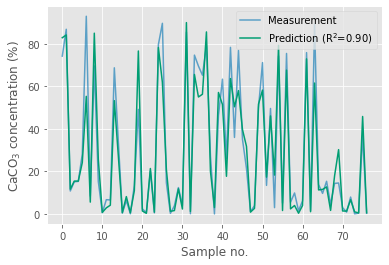

In [31]:
plt.plot(range(len(y_predict)), y_ttest, alpha=0.6, label='Measurement')
plt.plot(range(len(y_predict)), y_predict, label='Prediction (R$^2$={:.2f})'.format(r2_score(y_ttest, y_predict)))
#plt.text(12, -7, r'R$^2$={:.2f}, mean ab. error={:.2f}, max. ab. error={:.2f}'.format(grid.best_score_, mean_absolute_error(y_ttest, y_predict), max_error(y_ttest, y_predict)))
plt.ylabel('CaCO$_3$ concentration (%)')
plt.xlabel('Sample no.')
plt.legend(loc = 'upper right')
plt.savefig('results/caco3_predictions_nmr+svr_{}.png'.format(date))

### Visualization

In [3]:
#result_df = pd.DataFrame(grid.cv_results_)
#result_df.to_csv('results/caco3_grid_nmf+svr_{}.csv'.format(date))
result_df = pd.read_csv('results/caco3_grid_nmf+svr_20201013.csv', index_col = 0)
#result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

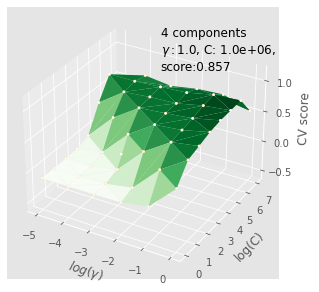

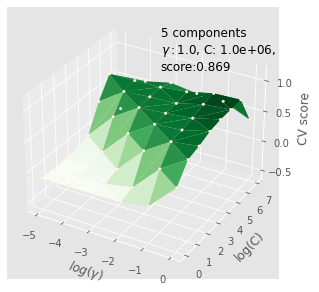

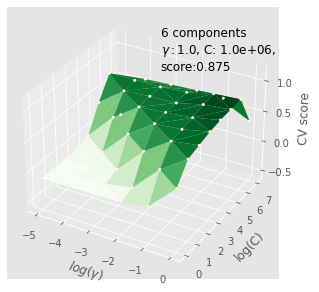

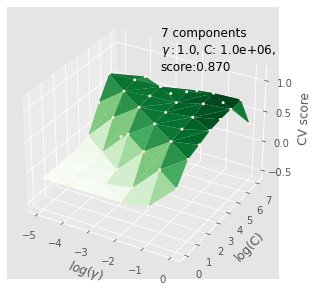

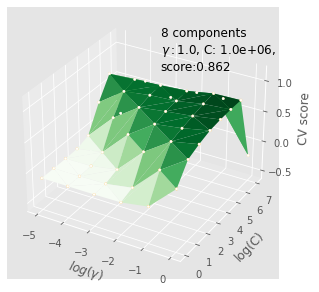

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

for n_components in [4, 5, 6, 7, 8]:
    data = result_df[result_df.param_nmf__n_components == n_components].reset_index(drop = True)
    fig = plt.figure(figsize = (7.3,5))
    ax = fig.gca(projection='3d')
    xx = data.param_svr__gamma.astype(float)
    yy = data.param_svr__C.astype(float)
    zz = data.mean_test_score.astype(float)
    max_index = np.argmax(zz)

    surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
    ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
    # mark the best score
    ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
    text = '{} components\n$\gamma :{:.1f}$, C: {:.1e},\nscore:{:.3f}'.format(n_components, xx[max_index], yy[max_index], zz[max_index])
    ax.text(np.log10(xx[max_index])-3, np.log10(yy[max_index]), 1,text, fontsize=12)
    
    ax.set_zlim(-.6, 1.2)
    ax.set_zticks(np.linspace(-.5, 1, 4))
    ax.set_xlabel('$log(\gamma)$')
    ax.set_ylabel('log(C)')
    ax.set_zlabel('CV score')
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    fig.savefig('results/caco3_grid_{}nmr+svr_3D_{}.png'.format(n_components, date))

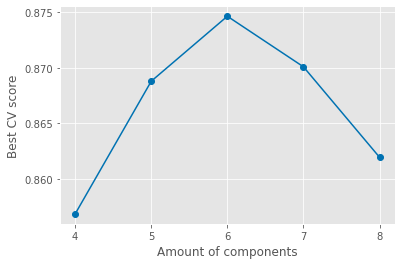

In [6]:
n_components = [4, 5, 6, 7, 8]
scores = []
for n in n_components:
    data = result_df[result_df.param_nmf__n_components == n].reset_index(drop = True)
    rank_min = data.rank_test_score.min()
    scores = np.hstack((scores, data.loc[data.rank_test_score == rank_min, 'mean_test_score'].values))
    
plt.plot(n_components, scores, marker='o')
plt.xticks(n_components)
plt.yticks(np.linspace(0.86, 0.875, 4))
plt.xlabel('Amount of components')
plt.ylabel('Best CV score')
plt.savefig('results/caco3_scores_components_{}.png'.format(date))

In [61]:
from joblib import dump, load
#model = load('models/tc_nmf+svr_model_20201012.joblib')
dump(grid.best_estimator_, 'models/caco3_nmf+svr_model_{}.joblib'.format(date)) 

['models/caco3_nmf+svr_model_20201013.joblib']

# Check prediction

In [62]:
spe_df = pd.read_csv('data/spe_dataset_20201008.csv', index_col = 0)
X = spe_df.iloc[:, :2048].values
X = X / X.sum(axis = 1, keepdims = True)

In [66]:
y_caco3 = np.exp(grid.best_estimator_.predict(X))

In [67]:
len(y_caco3[y_caco3 < 0])

0

In [68]:
len(y_caco3[y_caco3 > 100])

43

In [88]:
len(y_caco3[y_caco3 > 100])/len(y_caco3)

0.0012528407435464133

Yes, the negative-prediction issue is solved. Only 0.1 % of the predictions over 100. The previous model has 96% accuracy in the test set (build_models_01.ipynb), but has 8.5 % unrealistic predictions (prediction_01.ipynb). The enhanced model has lower score in the test set, 90%, but only has 0.1 % unrealistic predictions. Overall, the enhanced model here is better.